In [2]:
# Standard Library
import random

# Data Processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Spatial Analysis & GWR
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from geoshapley import GeoShapleyExplainer

# Utilities
from tqdm.auto import tqdm

c:\Users\hcz\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


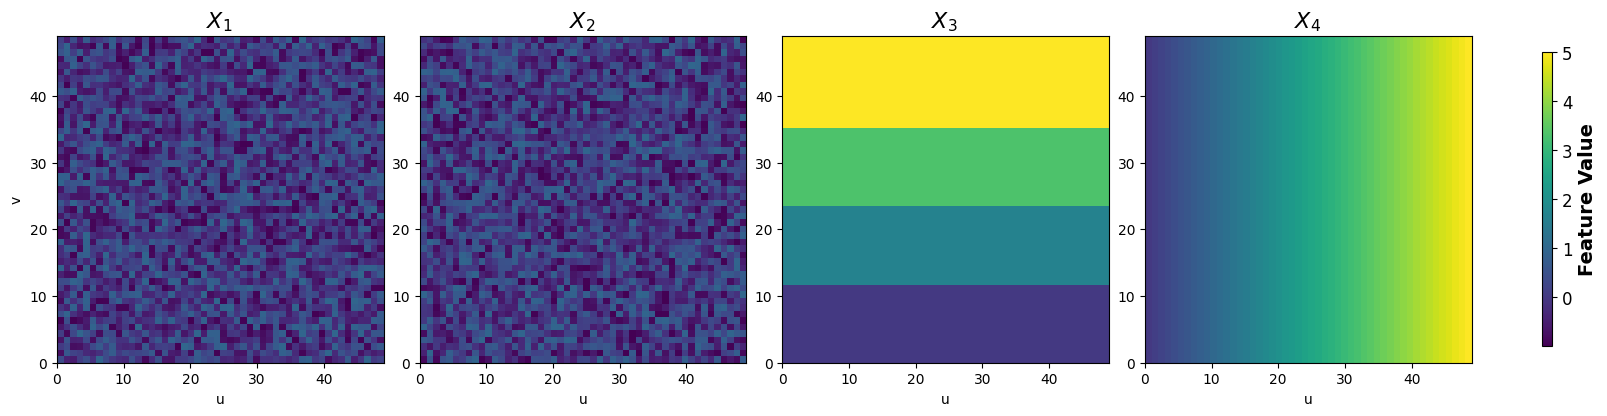

In [3]:
size = 50
np.random.seed(123)

X1 = np.random.uniform(-1, 1, (size, size))
X2 = np.random.uniform(-1, 1, (size, size))

X3 = np.zeros((size, size))
for i, val in enumerate([0.0, 1.67, 3.33, 5.0]):
    start = i * (size // 4)
    end = (i + 1) * (size // 4) if i < 3 else size
    X3[start:end, :] = val

X4 = np.tile(np.linspace(0, 5, size), (size, 1))

data = [X1, X2, X3, X4]
vmin, vmax = min(d.min() for d in data), max(d.max() for d in data)

fig, axes = plt.subplots(1, 4, figsize=(16, 4), constrained_layout=True)

for i, ax in enumerate(axes):
    im = ax.imshow(data[i], origin='lower', cmap='viridis', vmin=vmin, vmax=vmax, extent=[0, size-1, 0, size-1])
    ax.set_title(f"$X_{i+1}$ ", fontsize=16, fontweight='bold')
    ax.set(xlabel="u", ylabel="v" if i == 0 else "")

cbar = fig.colorbar(im, ax=axes, shrink=0.8, aspect=30)
cbar.set_label("Feature Value", fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

plt.show()

Figure 2: Spatial distribution of covariates

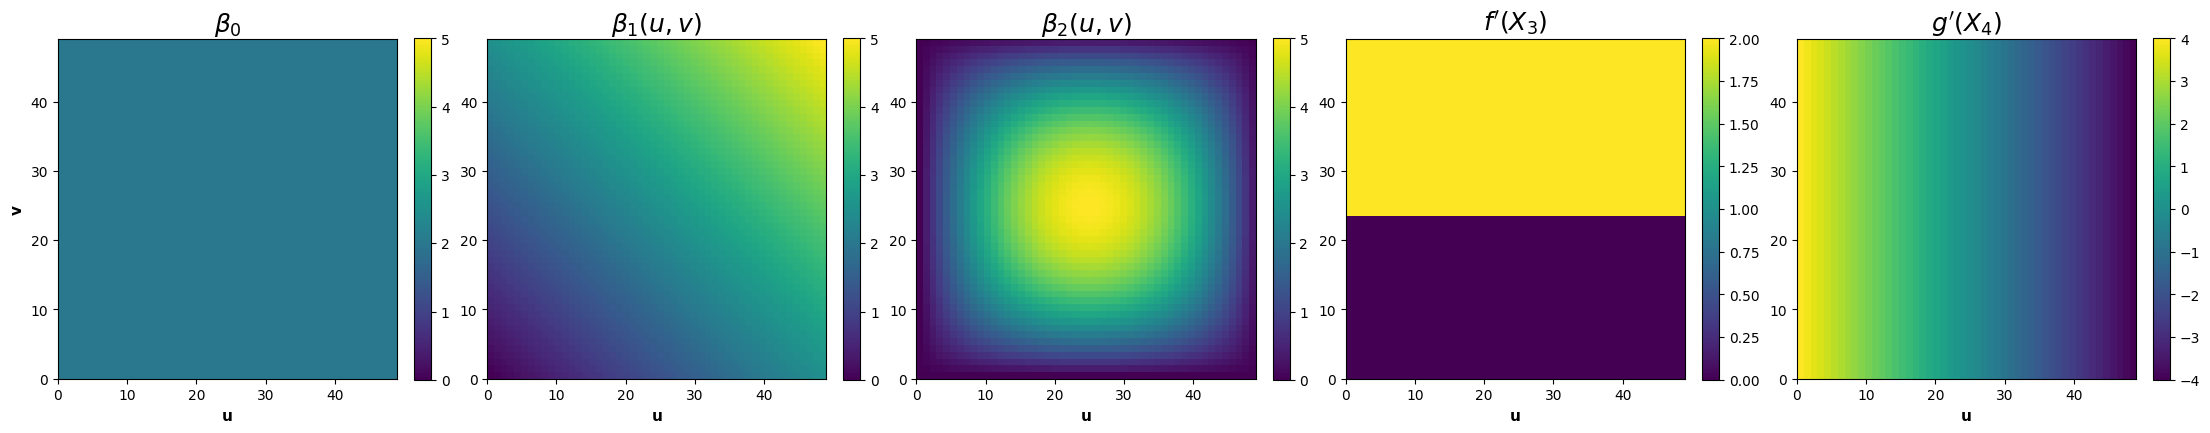

In [4]:
u, v = np.meshgrid(np.arange(size), np.arange(size))

beta0 = np.full((size, size), 2.0)
beta1 = (5.0 / 98.0) * (u + v)
beta2 = (5.0 / 24414.0625) * (156.25 - (12.5 - u/2)**2) * (156.25 - (12.5 - v/2)**2)

X3 = np.array([0.0, 1.67, 3.33, 5.0])[np.clip(v // (size // 4), 0, 3)]
f_prime = 2.0 * (X3 >= 2.5)

X4 = np.tile(np.linspace(0, 5, size), (size, 1))
g_prime = 2.0 * (-0.8 * X4 + 2.0)

data = [beta0, beta1, beta2, f_prime, g_prime]
titles = [r"$\beta_0$", r"$\beta_1(u,v)$", r"$\beta_2(u,v)$", r"$f'(X_3)$", r"$g'(X_4)$"]
limits = [(0, 5), (0, 5), (0, 5), (0, 2), (-4, 4)]

fig, axes = plt.subplots(1, 5, figsize=(22, 4.5), constrained_layout=True)

for ax, d, t, (vmin, vmax) in zip(axes, data, titles, limits):
    im = ax.imshow(d, origin="lower", extent=[0, size-1, 0, size-1], vmin=vmin, vmax=vmax, cmap='viridis')
    ax.set_title(t, fontsize=18, fontweight="bold")
    ax.set_xlabel("u", fontsize=11, fontweight='bold')
    if ax == axes[0]: ax.set_ylabel("v", fontsize=11, fontweight='bold')
    fig.colorbar(im, ax=ax, shrink=0.78).ax.tick_params(labelsize=10)

plt.show()

Figure 3: Visualization of the ground-truth components specified in the simulation: (a) constant intercept β0; (b) spatially varying coefficient β1(u,v) showing a global linear gradient; (c) spatially varying coefficient β2(u,v) showing a localized Gaussian hotspot; (d) marginal effect of the global nonlinear component f'(X3); and (e) marginal effect of the global nonlinear component g'(X4).

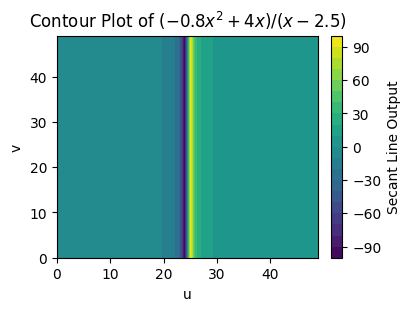

In [5]:
x = np.linspace(0, 5, size)
Z = np.tile((-0.8 * x**2 + 4 * x) / (x - 2.5), (size, 1))

plt.figure(figsize=(4, 3), constrained_layout=True)
plt.contourf(Z, 20, extent=[0, size-1, 0, size-1], cmap='viridis')
plt.colorbar(label='Secant Line Output')
plt.title(r"Contour Plot of $(-0.8x^2 + 4x)/(x-2.5)$")
plt.xlabel('u')
plt.ylabel('v')
plt.show()

Figure 4: Linearization Bias in GeoShapley Coefficient Estimation

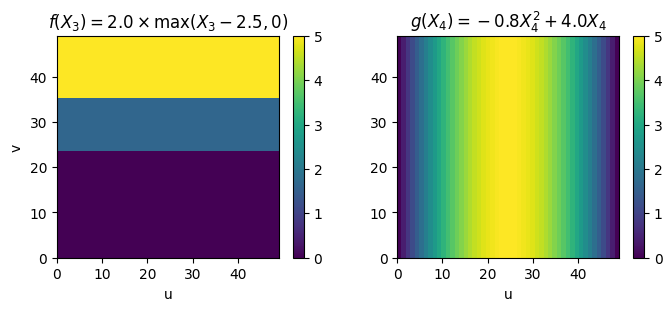

In [6]:
f_val = 2.0 * np.maximum(X3 - 2.5, 0)          # f(X3)
g_val = 2.0 * (-0.4 * X4**2 + 2.0 * X4)        # g(X4)

y = beta0 + beta1 * X1 + beta2 * X2 + f_val + g_val + 0.25 * np.random.randn(size, size)
fig, axes = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)

params = [
    (f_val, r"$f(X_3) = 2.0 \times \max(X_3 - 2.5, 0)$", None),
    (g_val, r"$g(X_4) = -0.8 X_4^2 + 4.0 X_4$", 5)
]

for ax, (data, title, vmax) in zip(axes, params):
    im = ax.imshow(data, origin='lower', extent=[0, size-1, 0, size-1], cmap='viridis', vmax=vmax)
    ax.set(title=title, xlabel='u', ylabel='v' if ax == axes[0] else '')
    fig.colorbar(im, ax=ax)

plt.show()

#MGWR simulation

Backfitting: 100%|██████████| 200/200 [04:14<00:00,  1.27s/it]


Bandwidths: [43. 46. 43. 43. 43.]


Inference: 100%|██████████| 1/1 [00:00<?, ?it/s]


R2: 0.9810182036470951


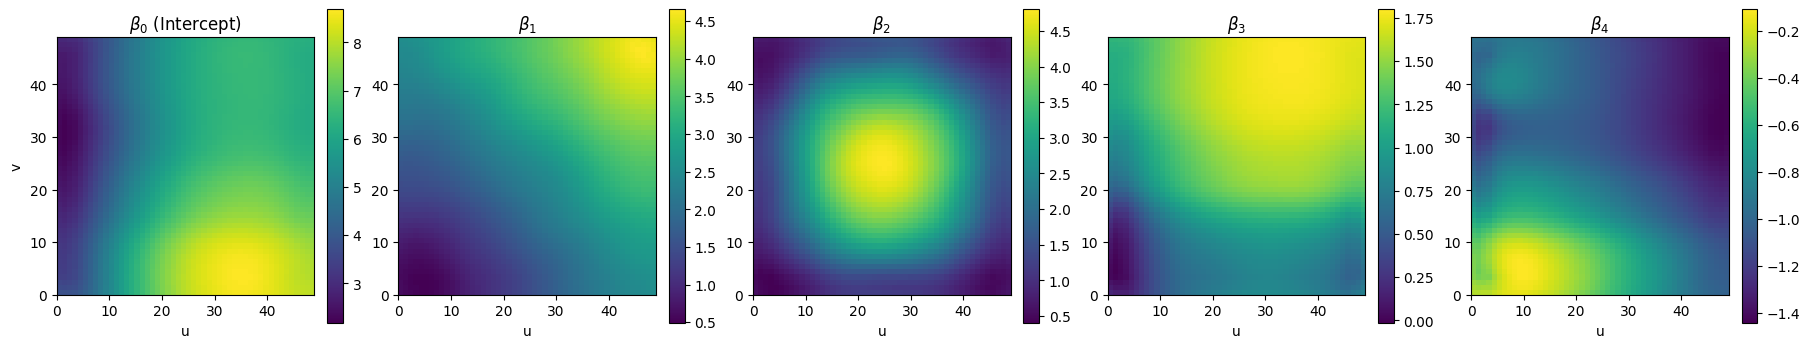

In [21]:
coords = np.column_stack([u.ravel(), v.ravel()])
X_in = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])
y_in = y.reshape(-1, 1)

selector = Sel_BW(coords, y_in, X_in, multi=True, kernel='gaussian', fixed=False, constant=True)
bw = selector.search()
print("Bandwidths:", bw)

model = MGWR(coords, y_in, X_in, selector=selector, kernel='gaussian', fixed=False, constant=True)
res = model.fit()
print("R2:", res.R2)

titles = [r"$\beta_0$ (Intercept)", r"$\beta_1$", r"$\beta_2$", r"$\beta_3$", r"$\beta_4$"]
fig, axes = plt.subplots(1, 5, figsize=(18, 4), constrained_layout=True)

for i, ax in enumerate(axes):
    im = ax.imshow(res.params[:, i].reshape(size, size), origin='lower', extent=[0, size-1, 0, size-1])
    ax.set_title(titles[i])
    ax.set(xlabel='u', ylabel='v' if i == 0 else '')
    fig.colorbar(im, ax=ax, shrink=0.8)

plt.show()

#SSNN simulation

100%|██████████| 4/4 [00:14<00:00,  3.66s/it]


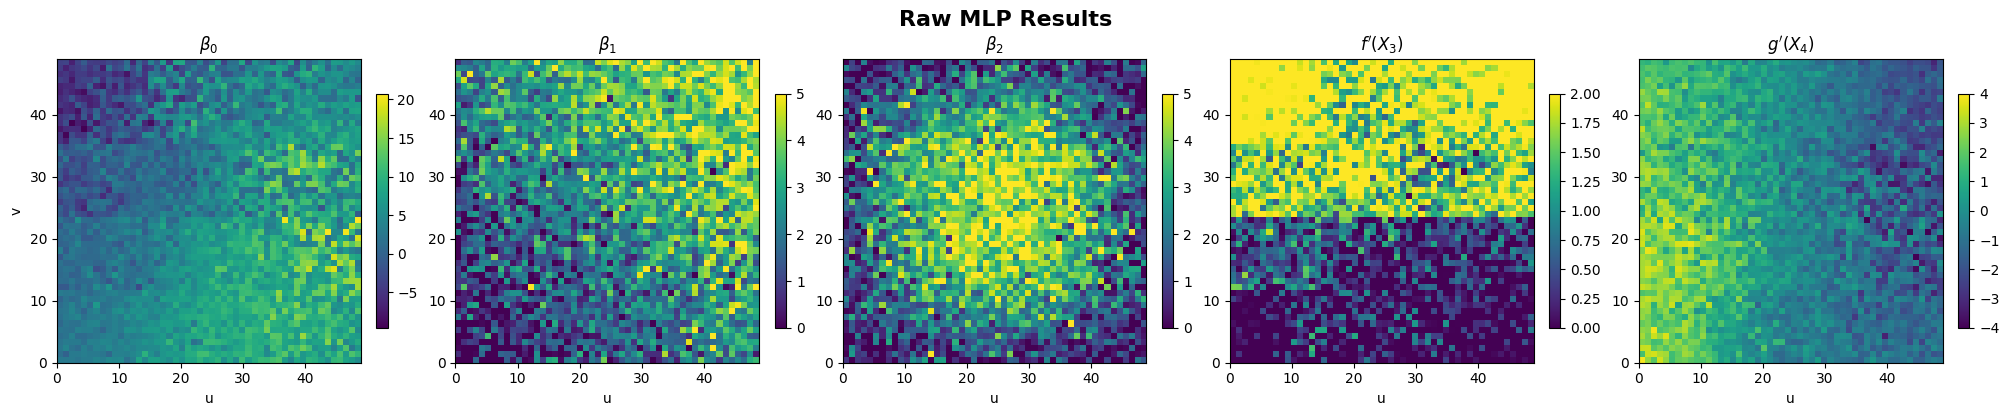

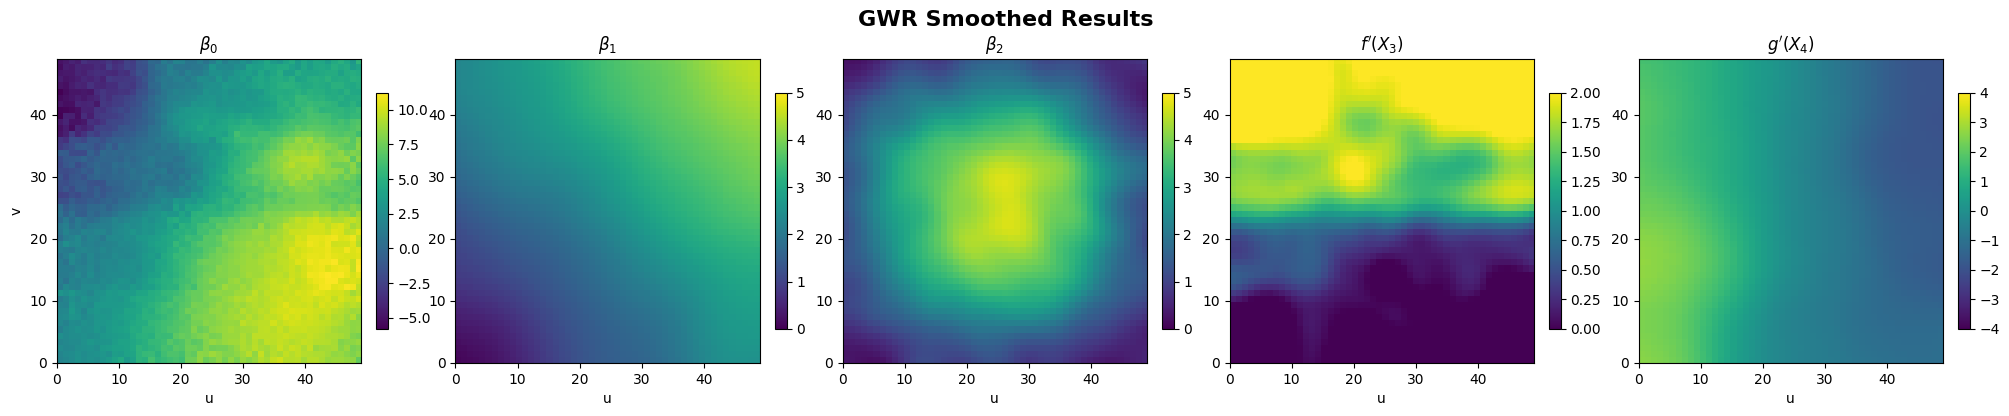

In [48]:
def seed_everything(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(123)

N = size * size
U, V = u / (size - 1), v / (size - 1)
inp = np.stack([U, V, X1, X2, X3, X4], axis=-1).reshape(N, 6).astype(np.float32)
tgt = y.reshape(N, 1).astype(np.float32)
ij_idx = np.stack(np.unravel_index(np.arange(N), (size, size)), axis=1)

perm = np.random.permutation(N)
split = int(0.8 * N)
train_ids, test_ids = perm[:split], perm[split:]

mu_x, sigma_x = inp[train_ids].mean(axis=0), inp[train_ids].std(axis=0) + 1e-8
mu_y, sigma_y = tgt[train_ids].mean(axis=0), tgt[train_ids].std(axis=0) + 1e-8
inp_std = (inp - mu_x) / sigma_x
tgt_std = (tgt - mu_y) / sigma_y

class GridDataset(Dataset):
    def __init__(self, x, y, ij):
        self.x, self.y, self.ij = x, y, ij
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, k): return self.x[k], self.y[k], self.ij[k]

train_loader = DataLoader(GridDataset(inp_std[train_ids], tgt_std[train_ids], ij_idx[train_ids]), batch_size=64, shuffle=True)
test_loader = DataLoader(GridDataset(inp_std[test_ids], tgt_std[test_ids], ij_idx[test_ids]), batch_size=64, shuffle=False)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 1)
        )
    def forward(self, x): return self.net(x)

model = MLP()
for m in model.modules():
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        nn.init.zeros_(m.bias)

opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
loss_fn = nn.MSELoss()

for epoch in range(1000):
    model.train()
    for xb, yb, _ in train_loader:
        loss = loss_fn(model(xb), yb)
        opt.zero_grad()
        loss.backward()
        opt.step()

sigma_x_t = torch.from_numpy(sigma_x).float()
sigma_y_t = torch.from_numpy(sigma_y).float()

def get_gradients(loader):
    out = []
    for xb, _, ij in loader:
        xb = xb.clone().requires_grad_(True)
        yhat = model(xb)
        grad_std = torch.autograd.grad(yhat.sum(), xb, create_graph=False)[0]
        grad_orig = grad_std * (sigma_y_t / sigma_x_t).to(grad_std.device)
        out.append(np.column_stack([grad_orig.detach().numpy()[:, 2:], ij.numpy()]))
    return np.concatenate(out, axis=0)

all_grads = np.concatenate([get_gradients(train_loader), get_gradients(test_loader)], axis=0)
raw_maps = [np.zeros((size, size)) for _ in range(4)]
ij_all = all_grads[:, 4:].astype(int)
for k in range(4):
    raw_maps[k][ij_all[:, 0], ij_all[:, 1]] = all_grads[:, k]

grads_flat = np.column_stack([m.ravel() for m in raw_maps]).astype(np.float64)
coords_geo = np.column_stack([u.ravel(), v.ravel()]).astype(np.float64)

class GradientSmoother:
    def smooth(self, coords, grads, bw_min=1):
        smoothed = np.zeros_like(grads)
        for j in tqdm(range(grads.shape[1])):
            y, X = grads[:, j:j+1], np.ones((grads.shape[0], 1))
            sel = Sel_BW(coords, y, X, kernel='bisquare', fixed=True, constant=False)
            bw = sel.search(bw_min=bw_min)
            model = GWR(coords, y, X, bw, kernel='bisquare', fixed=True, constant=False)
            smoothed[:, j] = model.fit().params.flatten()
        return smoothed

smoother = GradientSmoother()
grads_smooth_flat = smoother.smooth(coords_geo, grads_flat, bw_min=1)
smooth_maps = [grads_smooth_flat[:, i].reshape(size, size) for i in range(4)]

all_data_t = torch.from_numpy(inp_std)
with torch.no_grad():
    y_hat_orig = (model(all_data_t).numpy().ravel() * sigma_y + mu_y)

def calc_intercept(beta_list):
    b1, b2, b3, b4 = [b.ravel() for b in beta_list]
    interaction = b1 * X1.ravel() + b2 * X2.ravel() + b3 * X3.ravel() + b4 * X4.ravel()
    b0 = y_hat_orig - interaction
    return [b0.reshape(size, size)] + beta_list

final_raw = calc_intercept(raw_maps)
final_smooth = calc_intercept(smooth_maps)

def plot_maps(maps_list, title_prefix):
    titles = [r"$\beta_0$", r"$\beta_1$", r"$\beta_2$", r"$f'(X_3)$", r"$g'(X_4)$"]
    vmins = [None, 0, 0, 0, -4]
    vmaxs = [None, 5, 5, 2, 4]
    fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
    fig.suptitle(f"{title_prefix} Results", fontsize=16, fontweight='bold')
    for i, ax in enumerate(axes):
        im = ax.imshow(maps_list[i], origin='lower', extent=[0, size-1, 0, size-1], 
                       cmap='viridis', vmin=vmins[i], vmax=vmaxs[i])
        ax.set_title(titles[i])
        ax.set(xlabel="u", ylabel="v" if i==0 else "")
        fig.colorbar(im, ax=ax, shrink=0.7)
    plt.show()

plot_maps(final_raw, "Raw MLP")
plot_maps(final_smooth, "GWR Smoothed")

#GeoShapley simulation

  1%|          | 16/2500 [00:06<15:55,  2.60it/s]c:\Users\hcz\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 2500/2500 [01:58<00:00, 21.18it/s]


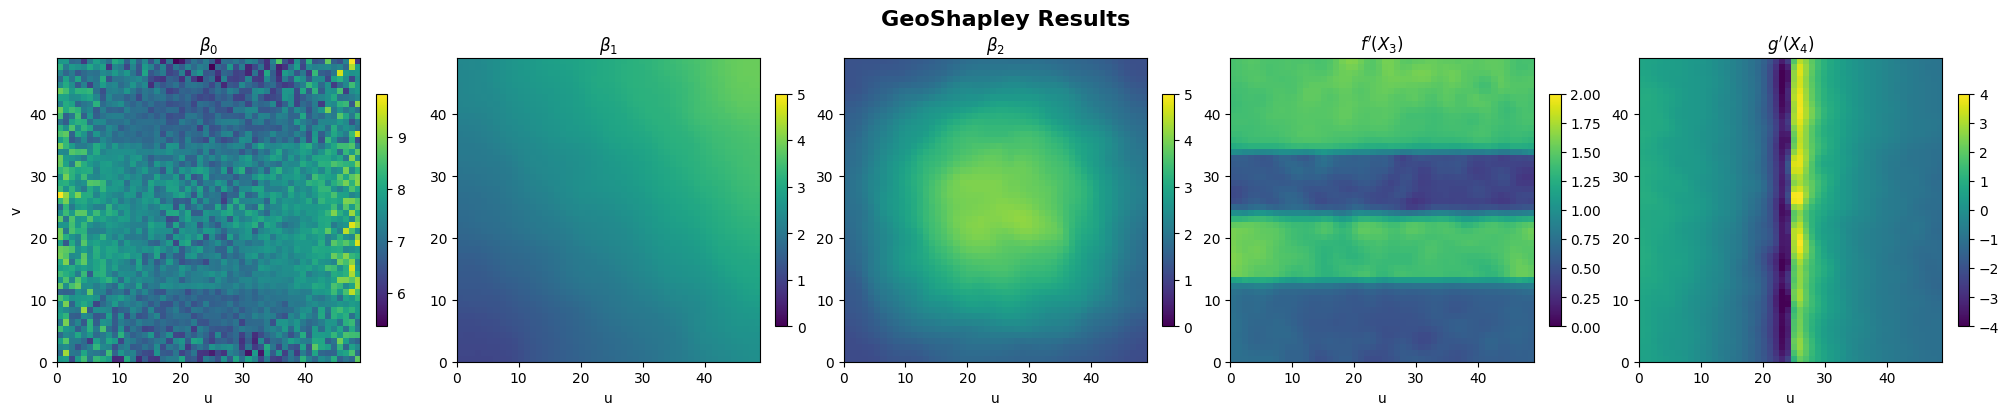

In [50]:
X_geo = pd.DataFrame({"U": U.ravel(), "V": V.ravel(), "X1": X1.ravel(), "X2": X2.ravel(), "X3": X3.ravel(), "X4": X4.ravel(), "x": u.ravel(), "y": v.ravel()})

@torch.no_grad()
def predict(d):
    d = d.values if hasattr(d, "values") else d
    x = torch.from_numpy((d[:, :6].astype(np.float32) - mu_x) / sigma_x)
    return (model(x).numpy() * sigma_y + mu_y).flatten()

gs = GeoShapleyExplainer(predict, X_geo.sample(100, random_state=1).values).explain(X_geo, n_jobs=-1)
svc = np.array(gs.get_svc(col=list(range(6)), coef_type="gwr", include_primary=True))

data = [
    (gs.base_value + gs.geo).reshape(size, size),
    svc[:, 2].reshape(size, size),
    svc[:, 3].reshape(size, size),
    svc[:, 4].reshape(size, size),
    svc[:, 5].reshape(size, size)
]
titles = [r"$\beta_0$", r"$\beta_1$", r"$\beta_2$", r"$f'(X_3)$", r"$g'(X_4)$"]
limits = [(None, None), (0, 5), (0, 5), (0, 2), (-4, 4)]

fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
fig.suptitle("GeoShapley Results", fontsize=16, fontweight='bold')

for ax, d, t, (vmin, vmax) in zip(axes, data, titles, limits):
    im = ax.imshow(d, origin='lower', extent=[0, size-1, 0, size-1], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set(title=t, xlabel="u", ylabel="v" if ax==axes[0] else "")
    fig.colorbar(im, ax=ax, shrink=0.7)

plt.show()

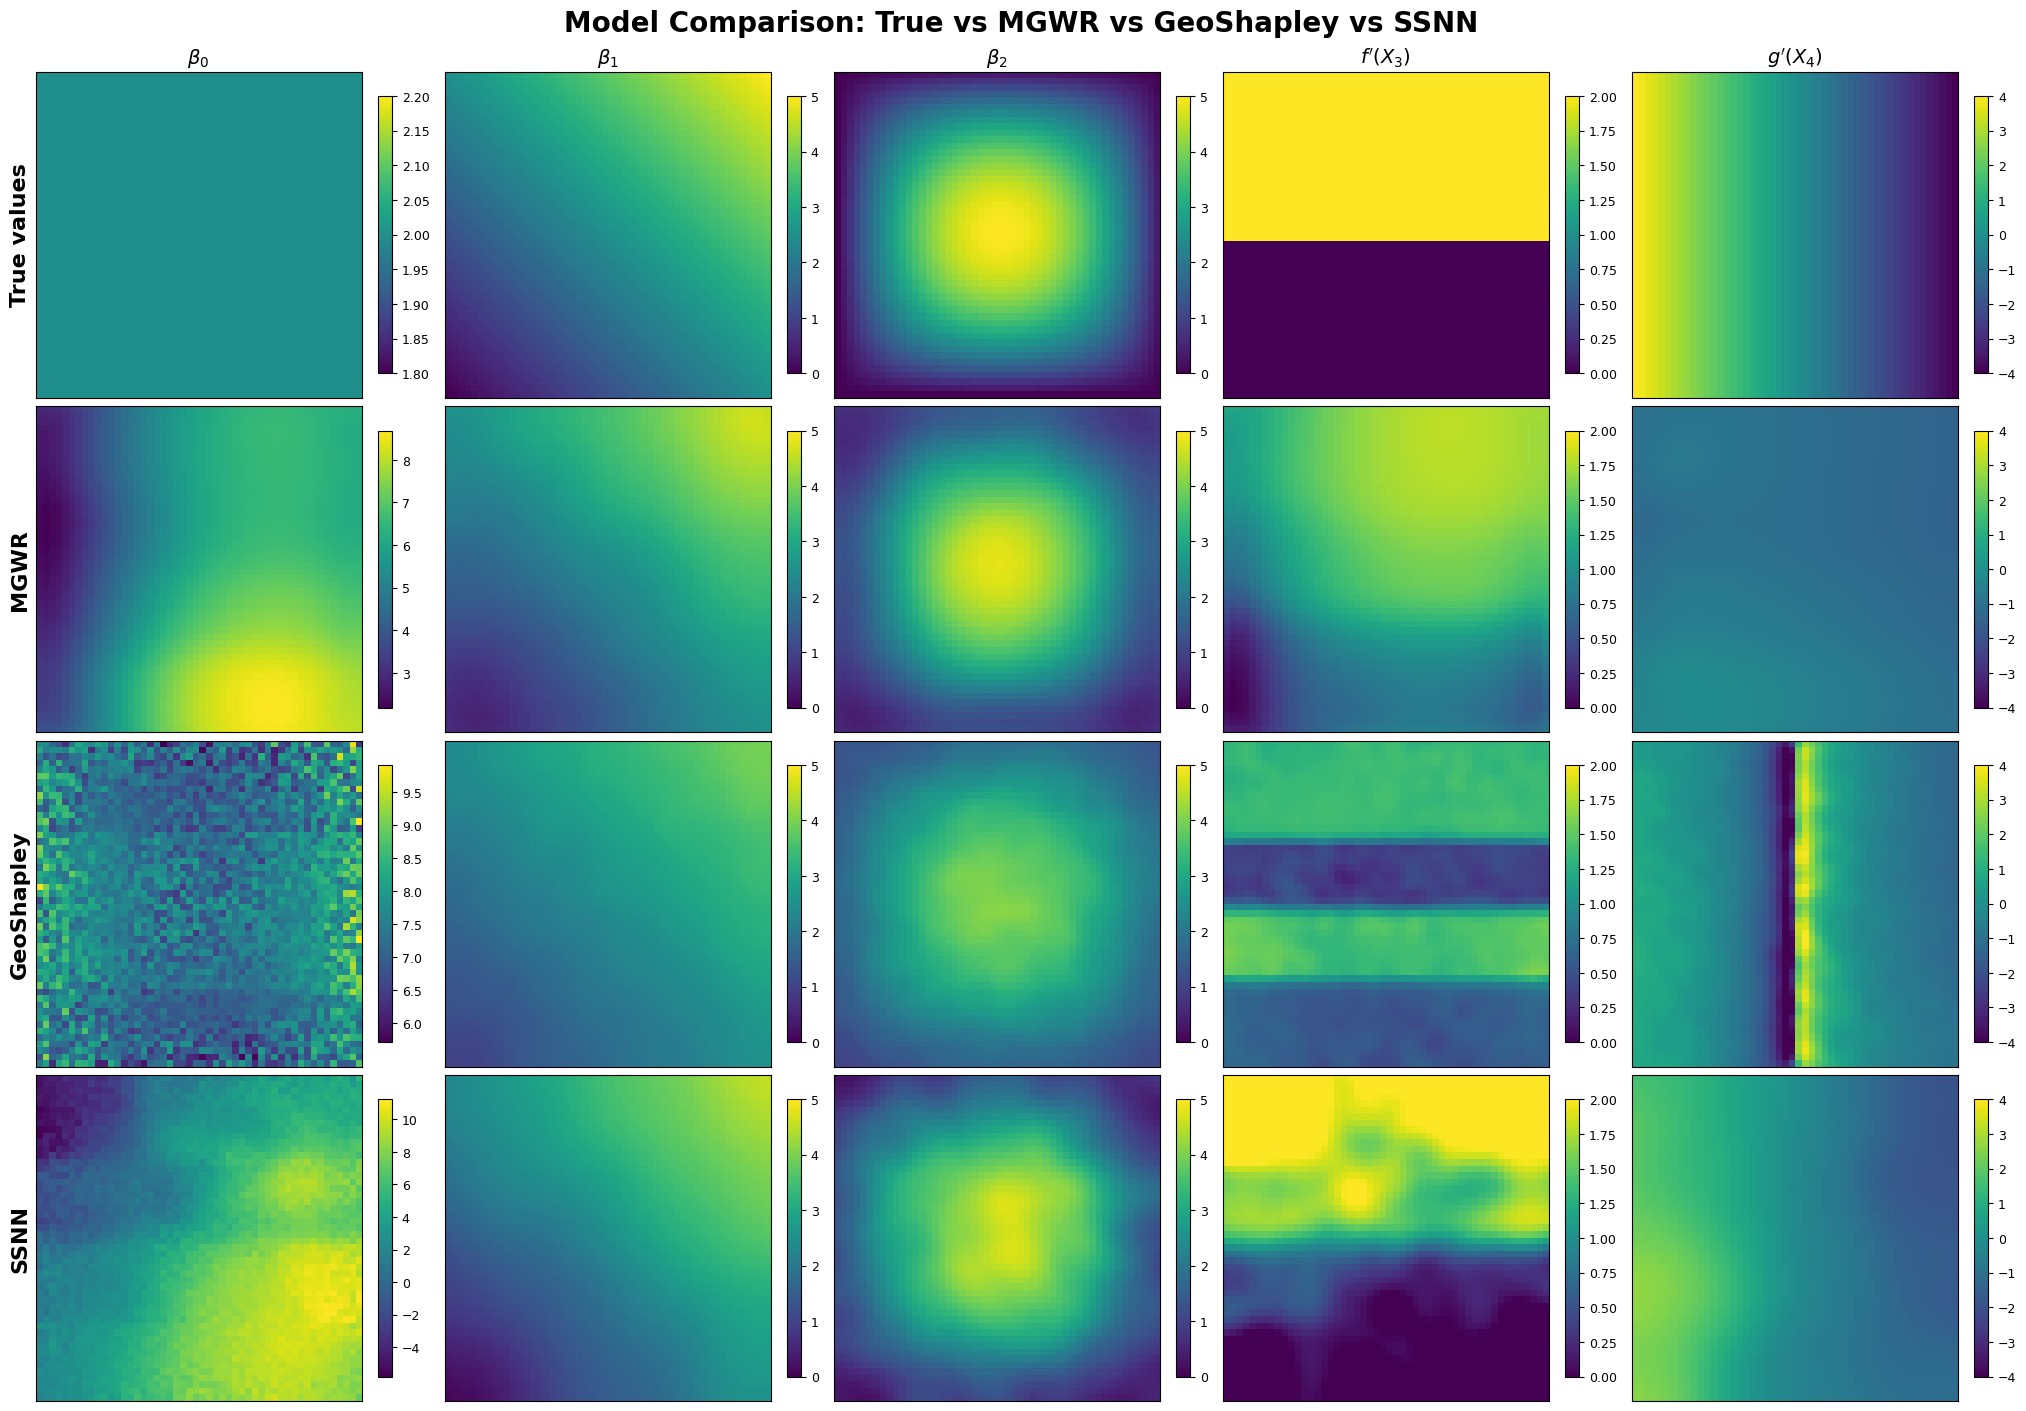

In [51]:
rows = [
    [beta0, beta1, beta2, f_prime, g_prime],
    [res.params[:, i].reshape(size, size) for i in range(5)],
    [beta0_gs, beta1_gs, beta2_gs, beta3_gs, beta4_gs],
    final_smooth
]
names = ["True values", "MGWR", "GeoShapley", "SSNN"]
titles = [r"$\beta_0$", r"$\beta_1$", r"$\beta_2$", r"$f'(X_3)$", r"$g'(X_4)$"]
limits = [(None, None), (0, 5), (0, 5), (0, 2), (-4, 4)]

fig, axes = plt.subplots(4, 5, figsize=(20, 14), constrained_layout=True)
fig.suptitle("Model Comparison: True vs MGWR vs GeoShapley vs SSNN", fontsize=20, fontweight='bold')

for i, (row, name) in enumerate(zip(rows, names)):
    for j, (data, title) in enumerate(zip(row, titles)):
        ax = axes[i, j]
        im = ax.imshow(data, origin='lower', extent=[0, size-1, 0, size-1], cmap='viridis', vmin=limits[j][0], vmax=limits[j][1])
        if i == 0: ax.set_title(title, fontsize=14, fontweight='bold')
        if j == 0: ax.set_ylabel(name, fontsize=16, fontweight='bold')
        ax.set_xticks([]); ax.set_yticks([])
        fig.colorbar(im, ax=ax, shrink=0.85).ax.tick_params(labelsize=9)

plt.show()

Figure 6: Simulation Results: From top to bottom, the spatially varying coefficients and global nonlinear marginal effects are shown for the true values, as well as those estimated by MGWR, GeoShapley, and SSNN

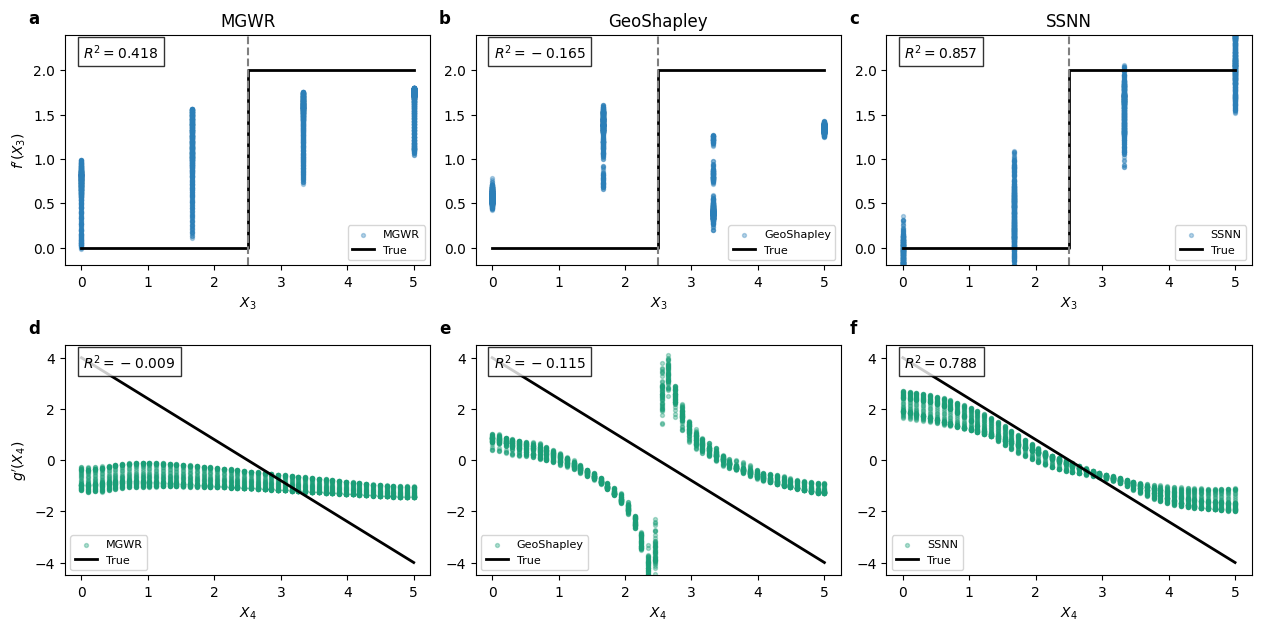

In [52]:
data = [
    ([res.params[:, 3], res.params[:, 4]], "MGWR"),
    ([svc_vals[:, 4], svc_vals[:, 5]], "GeoShapley"),
    ([final_smooth[3].ravel(), final_smooth[4].ravel()], "SSNN")
]

feats = [X3.ravel(), X4.ravel()]
truth = [f_prime.ravel(), g_prime.ravel()]
colors = ["#2C7FB8", "#1B9E77"]

def r2(y, p):
    return 1 - np.sum((y - p)**2) / (np.sum((y - y.mean())**2) + 1e-12)

fig, axes = plt.subplots(2, 3, figsize=(12.5, 6.2), constrained_layout=True)

for j, (preds, name) in enumerate(data):
    for i, (x, y, p) in enumerate(zip(feats, truth, preds)):
        ax = axes[i, j]
        ax.scatter(x, p, s=8, alpha=0.35, c=colors[i], label=name)
        
        if i == 0:
            ax.plot([x.min(), 2.5, 2.5, x.max()], [0, 0, 2, 2], 'k-', lw=2, label="True")
            ax.vlines(2.5, -0.2, 2.4, 'gray', '--')
            ax.set(ylim=(-0.2, 2.4), title=name, xlabel="$X_3$", ylabel=r"$f'(X_3)$" if j==0 else "")
            loc = "lower right"
        else:
            lx = np.linspace(x.min(), x.max(), 100)
            ax.plot(lx, 2*(-0.8*lx + 2), 'k-', lw=2, label="True")
            ax.set(ylim=(-4.5, 4.5), xlabel="$X_4$", ylabel=r"$g'(X_4)$" if j==0 else "")
            loc = "lower left"

        ax.text(0.05, 0.9, f"$R^2={r2(y, p):.3f}$", transform=ax.transAxes, bbox=dict(fc="w", alpha=0.8))
        ax.text(-0.1, 1.05, "abcdef"[j + i*3], transform=ax.transAxes, weight='bold', size=12)
        ax.legend(loc=loc, fontsize=8)

plt.show()

Figure 7: MGWR, GeoShapley, and SSNN recovering f'(X3) and g'(X4)